In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"
weight_path='saved_model/resnet50v2TL_20epochs_32batch.h5'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 6000 files belonging to 500 classes.
Using 4800 files for training.
Metal device set to: Apple M1


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

In [ ]:
X = []
y = []
for img, label in data:
    X.append(img)
    y.append(label)

In [ ]:
len(X)

In [7]:
from keras.applications.resnet_v2 import ResNet50V2

def resnet_model_tf(input_shape=(128, 128, 3), nombre_classes=500):
    resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet.tbatch_sizenable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
    return model, learning_rate_reduction

In [8]:
model, learning_rate_reduction = resnet_model_tf()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2

In [9]:
# Loads the weights
model.load_weights(weight_path)

In [15]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            #X.append([np.array(img), np.array(img), np.array(img)])
            #X.append(np.array(img))
            #X.append(np.array(img))
            #X.append(np.array(img))
            stacked_img = np.stack((img,)*3, axis=-1)
            X.append(stacked_img)
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [16]:
X, y, label_names = load_img(path_data, nb_of_users=500, xdim=128, ydim=128)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

6000  images lues

X.shape =  (6000, 128, 128, 3)
y.shape =  (6000,)


In [17]:
X = X / 255.
#X = X.reshape(6000, 128, 128, 3)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))
print("\n\n-----------------------------------------")
print("Il y a {} utilisateur(s) dans le dataset prélevé.".format(y.shape[1]))


PREPROCESSING DATA
-----------------------------------------

X shape : (6000, 128, 128, 3)
-----------------------------------------
y shape : (6000, 500)



-----------------------------------------
Il y a 500 utilisateur(s) dans le dataset prélevé.


194


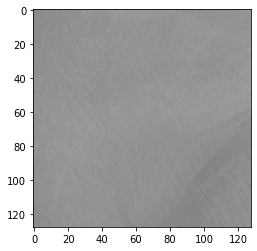

In [18]:
j = randrange(y.shape[1])
print(j)
plt.imshow(X[j], cmap='gray')
#plt.imshow(X[j])
plt.show()
#print("\ny : \n",y[j])
#print(X[j])

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print("\nSplitting data ...\n")
print("-----------------------------------------------------------------------------------------")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_test shape  : {}    |   y_test shape  : {}".format(X_test.shape, y_test.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_val shape   : {}    |   y_val shape   : {}".format(X_val.shape, y_val.shape))


Splitting data ...

-----------------------------------------------------------------------------------------

X_train shape : (4200, 128, 128, 3)    |   y_train shape : (4200, 500)
-----------------------------------------------------------------------------------------

X_test shape  : (900, 128, 128, 3)    |   y_test shape  : (900, 500)
-----------------------------------------------------------------------------------------

X_val shape   : (900, 128, 128, 3)    |   y_val shape   : (900, 500)


In [20]:
y_pred = model.predict(X_test)

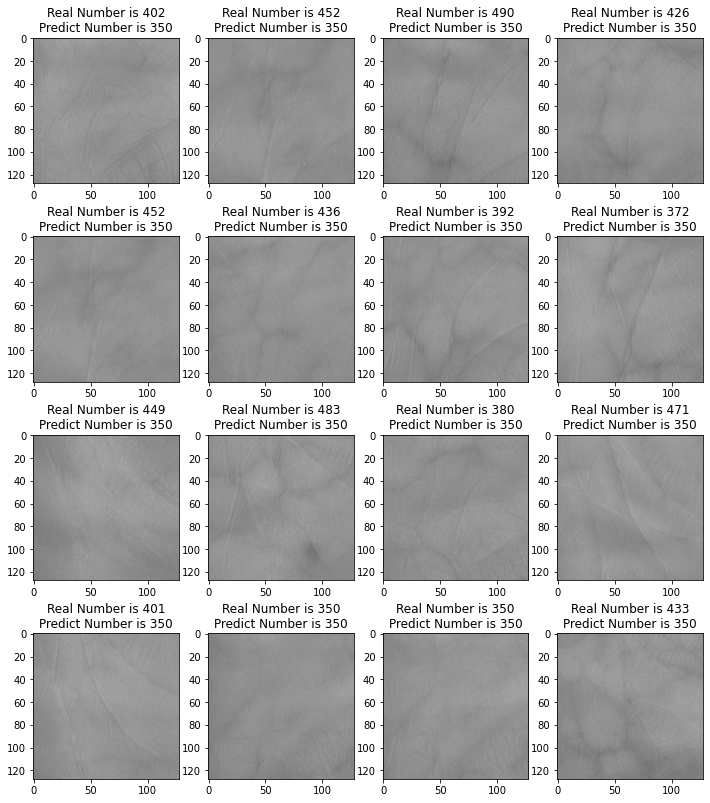

In [21]:
X_test__ = X_test.reshape(X_test.shape[0], 128, 128, 3)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i])
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

In [ ]:
# Re-evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [10]:
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

29/29 - 4s - loss: 0.0095 - accuracy: 0.9978
Restored model, accuracy: 99.78%


In [11]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.


In [12]:
pred_res=model.predict(ds)

In [13]:
pred_res.shape

(6000, 500)

In [24]:
ds

<BatchDataset shapes: ((None, 128, 128, 3), (None, 500)), types: (tf.float32, tf.float32)>

TypeError: 'BatchDataset' object is not subscriptable

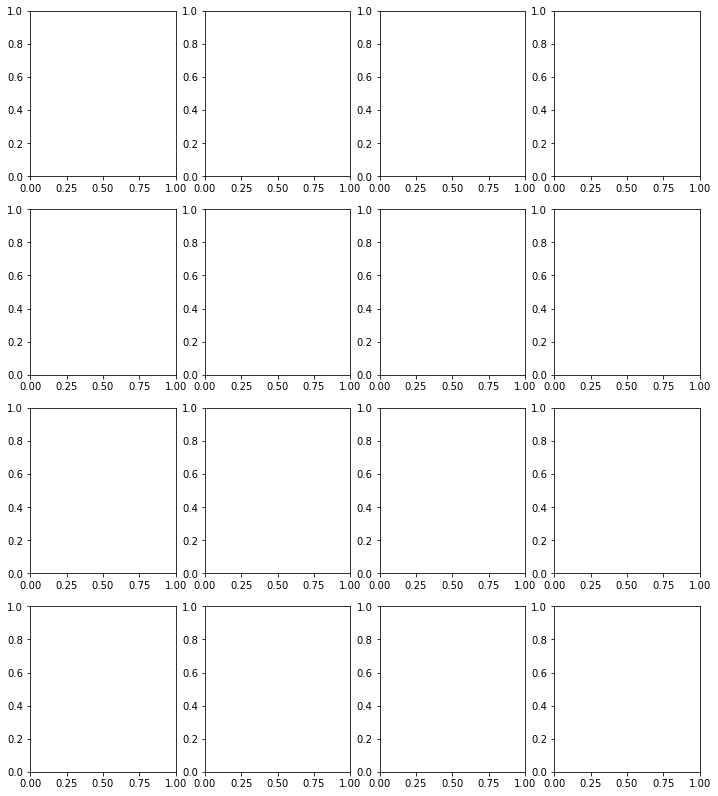

In [14]:
fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(ds[i])
    ax.set(title = f"Real Number is {ds[i].argmax()}\nPredict Number is {pred_res[i].argmax()}");

In [ ]:

first_pred=(np.array(pred_res)[:,:,1])[0][0], np.round(float(np.array(pred_res)[:,:,2][0][0])*100,1)
second_pred=(np.array(pred_res)[:,:,1])[0][1], np.round(float(np.array(pred_res)[:,:,2][0][1])*100,1)
third_pred=(np.array(pred_res)[:,:,1])[0][2], np.round(float(np.array(pred_res)[:,:,2][0][2])*100,1)

print('{:18} | {}'.format('Predicted Label', 'Confidence (%)'))
print('{:18} | {}'.format(first_pred[0], first_pred[1])) 
print('{:18} | {}'.format(second_pred[0], second_pred[1])) 
print('{:18} | {}'.format(third_pred[0], third_pred[1]))

fig=plt.imshow(img)
plt.title('{} ({}%)'.format(first_pred[0], first_pred[1]))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [ ]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 